In [72]:
from pytorch_tabnet.tab_model import TabNetClassifier

import os
import torch
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
 
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [73]:
folder1 = "Data/Nuevos Datos Ligas"
ligas = ["bundesliga", "ligue-1", "premier-league", "serie-a"]
torneos = {}

for liga in ligas:
    match_file = f"features-{liga}.csv"
    try:
        path_matches = os.path.join(folder1, match_file)
        matches = pd.read_csv(path_matches)
    except FileNotFoundError:
        continue
    torneos[liga] = matches #diccionario. key: liga, value: dataframe

In [74]:
print(torneos.keys())
print(torneos["bundesliga"].columns)

dict_keys(['bundesliga', 'ligue-1', 'premier-league', 'serie-a'])
Index(['Season', 'number_of_match', 'Home Team', 'Away Team', 'Result',
       'HTW_rate', 'HTD_rate', 'HTL_rate', 'ATW_rate', 'ATD_rate', 'ATL_rate',
       'HTHW_rate', 'HTHD_rate', 'HTHL_rate', 'ATAW_rate', 'ATAD_rate',
       'ATAL_rate', '1_Last_HTW', '2_Last_HTW', '3_Last_HTW', '1_Last_HTD',
       '2_Last_HTD', '3_Last_HTD', '1_Last_HTHW', '2_Last_HTHW', '1_Last_ATW',
       '2_Last_ATW', '3_Last_ATW', '1_Last_ATD', '2_Last_ATD', '3_Last_ATD',
       '1_Last_ATWA', '2_Last_ATWA', '7_HTW_rate', '12_HTW_rate', '7_HTD_rate',
       '12_HTD_rate', '7_ATW_rate', '12_ATW_rate', '7_ATD_rate', '12_ATD_rate',
       '5_HTHW_rate', '5_ATAW_rate'],
      dtype='object')


Ahora, se eliminan las columnas que tengan datos faltantes.

In [75]:
columns_with_null = []

for torneo in torneos.values():
    null_columns = torneo.columns[torneo.isna().any()].tolist()
    columns_with_null.append(null_columns)

columns_with_null

unique_columns = list(set(itertools.chain.from_iterable(columns_with_null)))
unique_columns

#Borrar para cada torneo las columnas en unique_columns
for torneo in torneos.values():
    torneo.drop(columns=unique_columns, inplace=True)

In [76]:
#Cantidad de datos en cada torneo

torneos["bundesliga"].head()

,Season,number_of_match,Home Team,Away Team,Result,HTW_rate,HTD_rate,HTL_rate,ATW_rate,ATD_rate,...,1_Last_HTHW,2_Last_HTHW,1_Last_ATW,2_Last_ATW,3_Last_ATW,1_Last_ATD,2_Last_ATD,3_Last_ATD,1_Last_ATWA,2_Last_ATWA
0,23-24,233,Borussia Dortmund,Eintracht Frankfurt,H,0.615385,0.153846,0.230769,0.285714,0.357143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,23-24,232,SC Freiburg,Bayer 04 Leverkusen,A,0.384615,0.384615,0.230769,0.846154,0.153846,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,23-24,231,TSG Hoffenheim,VfB Stuttgart,A,0.230769,0.307692,0.461538,0.615385,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,23-24,230,VfL Wolfsburg,FC Augsburg,A,0.307692,0.307692,0.384615,0.307692,0.230769,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,23-24,229,Darmstadt 98,FC Bayern München,A,0.071429,0.214286,0.714286,0.615385,0.153846,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


### Procesar Partidos

In [77]:
#eliminar columnas: Home Team, Away Team y number_of_match
for torneo in torneos.values():
    torneo.drop(columns=["Home Team", "Away Team", "number_of_match"], inplace=True)

In [78]:
torneos["bundesliga"].head()

,Season,Result,HTW_rate,HTD_rate,HTL_rate,ATW_rate,ATD_rate,ATL_rate,HTHW_rate,HTHD_rate,...,1_Last_HTHW,2_Last_HTHW,1_Last_ATW,2_Last_ATW,3_Last_ATW,1_Last_ATD,2_Last_ATD,3_Last_ATD,1_Last_ATWA,2_Last_ATWA
0,23-24,H,0.615385,0.153846,0.230769,0.285714,0.357143,0.357143,0.615385,0.153846,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,23-24,A,0.384615,0.384615,0.230769,0.846154,0.153846,0.000000,0.384615,0.384615,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,23-24,A,0.230769,0.307692,0.461538,0.615385,0.000000,0.384615,0.230769,0.307692,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,23-24,A,0.307692,0.307692,0.384615,0.307692,0.230769,0.461538,0.307692,0.307692,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,23-24,A,0.071429,0.214286,0.714286,0.615385,0.153846,0.230769,0.071429,0.214286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [79]:
#Solo vamos a usar desde la temporada 14-15 por la cantidad de datos
seasons = ["14-15", "15-16", "16-17", "17-18", "18-19", "19-20", "20-21", "21-22", "22-23", "23-24"]
partidos_full = []
for torneo in torneos.values():
    #solo usamos los partidos en seasons
    torneo = torneo[torneo["Season"].isin(seasons)]
    #reiniciar el index
    torneo.reset_index(drop=True, inplace=True)
    partidos_full.append(torneo)


In [80]:
#unir todos los dataframes
matches = pd.concat(partidos_full)


In [81]:
#Cantidad de partidos por resultado (local, empate, visita)
for i in ["H", "D", "A"]:
    cantidad = matches[matches["Result"]==i].shape[0]
    print(f"Resultado {i}, hay: {cantidad} partidos, {cantidad*100/len(matches)}%")

Resultado H, hay: 5471 partidos, 44.12808517502823%
Resultado D, hay: 3092 partidos, 24.939506371995485%
Resultado A, hay: 3835 partidos, 30.932408452976286%


Ahora, separamos los datos para entrenar y para predecir.

In [82]:
#Ahora,vamos a separar las 3 ultimas temporadas para test
ultimas_temporadas = ["21-22", "22-23", "23-24"]

matches_test = matches[matches["Season"].isin(ultimas_temporadas)]
matches_train = matches[~matches["Season"].isin(ultimas_temporadas)]

#print de la cantidad de partidos en train y test
print(f"Partidos en train: {len(matches_train)}")
print(f"Partidos en test: {len(matches_test)}")
print(f"Total de partidos: {len(matches)}")


result_train = matches_train["Result"]
result_test = matches_test["Result"]
matches_train = matches_train.drop(columns = ["Result", "Season"])
matches_test = matches_test.drop(columns = ["Result", "Season"])

matches.tail()

Partidos en train: 9277
Partidos en test: 3121
Total de partidos: 12398


,Season,Result,HTW_rate,HTD_rate,HTL_rate,ATW_rate,ATD_rate,ATL_rate,HTHW_rate,HTHD_rate,...,1_Last_HTHW,2_Last_HTHW,1_Last_ATW,2_Last_ATW,3_Last_ATW,1_Last_ATD,2_Last_ATD,3_Last_ATD,1_Last_ATWA,2_Last_ATWA
3339,14-15,H,0.369811,0.358491,0.271698,0.271698,0.358491,0.369811,0.369811,0.358491,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3340,14-15,H,0.369811,0.358491,0.271698,0.271698,0.358491,0.369811,0.369811,0.358491,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3341,14-15,D,0.369811,0.358491,0.271698,0.271698,0.358491,0.369811,0.369811,0.358491,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3342,14-15,H,0.369811,0.358491,0.271698,0.271698,0.358491,0.369811,0.369811,0.358491,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3343,14-15,A,0.369811,0.358491,0.271698,0.271698,0.358491,0.369811,0.369811,0.358491,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
result = matches["Result"]
matches = matches.drop(columns = ["Result", "Season"])
matches.head()

columnas_categoricas = matches.select_dtypes(include=['object']).columns.tolist()

print("Columnas categóricas:")
print(columnas_categoricas)

Columnas categóricas:
[]


In [85]:
'''
X = matches.to_numpy()
scaler = StandardScaler()
X_escalados = scaler.fit_transform(X)
y = result
'''

X = matches_train.to_numpy()
scaler = StandardScaler()
X_train = scaler.fit_transform(X)
y_train = result_train

X_test = scaler.transform(matches_test.to_numpy())
y_test = result_test

In [99]:
clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    scheduler_params={"step_size":50, # how to use learning rate scheduler
                        "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax', # "sparsemax" "entmax"
    )
    
clf.fit(X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    eval_name=['train', 'valid'], 
    eval_metric=['accuracy'], 
    max_epochs=1000 , patience=100, 
    batch_size=28, drop_last=False)

pred = clf.predict(X_test)

/Users/gustavofernandez/Desktop/Ing Civil/2024-1/IIC2985/iPre-resultados-deportivos/env/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.22006 | train_accuracy: 0.46998 | valid_accuracy: 0.48734 |  0:00:03s
epoch 1  | loss: 1.06534 | train_accuracy: 0.51795 | valid_accuracy: 0.50112 |  0:00:07s
epoch 2  | loss: 1.0167  | train_accuracy: 0.52668 | valid_accuracy: 0.51073 |  0:00:11s
epoch 3  | loss: 0.98222 | train_accuracy: 0.54975 | valid_accuracy: 0.52515 |  0:00:15s
epoch 4  | loss: 0.96534 | train_accuracy: 0.55061 | valid_accuracy: 0.53669 |  0:00:18s
epoch 5  | loss: 0.95605 | train_accuracy: 0.55988 | valid_accuracy: 0.56008 |  0:00:21s
epoch 6  | loss: 0.94063 | train_accuracy: 0.56009 | valid_accuracy: 0.55912 |  0:00:24s
epoch 7  | loss: 0.93494 | train_accuracy: 0.55999 | valid_accuracy: 0.5652  |  0:00:28s
epoch 8  | loss: 0.93603 | train_accuracy: 0.56839 | valid_accuracy: 0.56392 |  0:00:31s
epoch 9  | loss: 0.93095 | train_accuracy: 0.56592 | valid_accuracy: 0.55944 |  0:00:34s
epoch 10 | loss: 0.92781 | train_accuracy: 0.57023 | valid_accuracy: 0.57065 |  0:00:37s
epoch 11 | loss: 0.92

/Users/gustavofernandez/Desktop/Ing Civil/2024-1/IIC2985/iPre-resultados-deportivos/env/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [100]:
print("classification report")
print(classification_report(y_test, pred))

classification report
              precision    recall  f1-score   support

           A       0.59      0.61      0.60       974
           D       0.50      0.34      0.40       772
           H       0.65      0.75      0.70      1375

    accuracy                           0.60      3121
   macro avg       0.58      0.56      0.56      3121
weighted avg       0.59      0.60      0.59      3121



Normalized confusion matrix


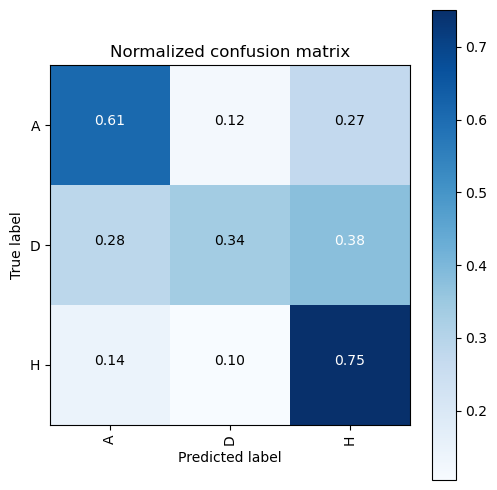

In [89]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(y_test, pred)
classes = np.unique(y_train)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure(figsize=(5,5))

plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()

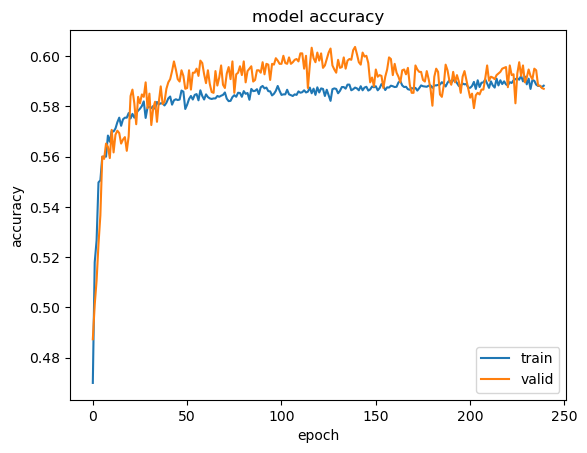

In [103]:
#grafico accuracy
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()